<a href="https://colab.research.google.com/github/makkimaki/python-bayes-intro/blob/main/%E3%81%99%E3%82%89%E3%81%99%E3%82%89%E3%83%99%E3%82%A4%E3%82%BA%E5%86%99%E7%B5%8C_3%E2%88%923_%E3%80%90IRT_evaluation%E3%80%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IRT(Item Response Theory)によるテスト結果評価

本節の目的：**既存のモデル（統計モデル、機械学習モデル）ではない数学モデルから、ベイズモデルを構築する**

項目反応理論を取り上げ、この数学モデルをベイズ的に実装していく。

これまでと異なる点
1. 観測値データが表形式→従って、いずれ一次元化する加工が必要
2. 観測値データが膨大なため、推論に時間がかかる⇨短時間で行う方法として、変分推論法を活用

## IRTとは？
モデルはいくつも種類があるが、まずは**１パラメータ・ロジスティックモデル(1PLM)**の説明。
- 目的：受験者の能力値と、試験各設問の特性（困難度）を同時に予測する
- 受験者はそれぞれ個別の能力値を持つと考える
- 試験設問も、個別の困難度を持つとする
- 確率変数は、**能力値と困難度の関数**であると考える（ナイーブな考えでは、ある受験者の特定の設問に対する**正答率**が確率変数にするがここではそうしない）

本節では、2PLMを取り上げる。
- 設問固有のパラメータは、困難度だけでなく**識別力**もあると考える
    - 識別力：受験者のレベルを変えた時に、正答率がどの程度変化するかの度合いを示すパラメータ
- パラメータ一覧
$$ \theta_i: 能力値$$
$$ b_j: 困難度 $$
$$　a_j: 識別力$$
２PLMではシグモイド関数$f(x) = 1/(1+e^{-x})$を用いて
$$ f(a_j(\theta_i - b_j))$$
と表す。なお、この時の$f(x)$は正答率と解釈すれば良い。


In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=d7686f37b4208d0248ac94c99d9e013a308b5022d0da01cf910a6587a6780126
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.7.2'
sns.__version__='0.12.0'
np.__version__='1.23.5'


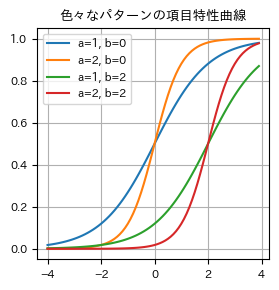

In [3]:
x = np.arange(-4, 4, 0.1)
abset = [(1, 0), (2, 0), (1, 2), (2, 2)]

def sigmoid(x, a=1, b=1):
    return 1 / (1 + np.exp(-a*(x-b)))

plt.figure()
for abitem in abset:
    a, b = abitem
    plt.plot(x, sigmoid(x, a=a, b=b), label=f"{a=}, {b=}")

plt.legend()
plt.title("色々なパターンの項目特性曲線")
plt.show()

↑各曲線は、それぞれ設問と考えて良い。（識別力、困難度）のセットで１つの設問になり、受験者$j$の能力値$\theta_j$に応じて**正答率**が変化する。

## 問題設定
受験者：1000  
設問：50  
正答：1  
誤答：0

目的：設問別の困難度・識別力と、受験者別の能力値を同時に推定する  
⇨**特に、見かけ状の点数が同じであっても、受験者の能力値の違いを導出することが可能になる
**

In [4]:
url = "https://github.com/makaishi2/samples/raw/main/data/irt-sample.csv"
df = pd.read_csv(url, index_col=0)

print(df.shape)
display(df.head())

(1000, 50)


,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0


### データ加工
表形式のデータを観測として確率モデルに渡すには、`pandas.melt`, `pandas.factorize`を活用する。


In [5]:
# meltで、横持ち形式を縦持ちに変換
response_df = pd.melt(
    df.reset_index(),
    id_vars="index",
    var_name="question",
    value_name="response"
)

# 列名indexをuserに変換
response_df = response_df.rename({"index": "user"}, axis=1)

# 要素数の変化を確認
print(f"元データ(df): , {df.shape}")
print(f"変換後データ(response_df): , {response_df.shape}\n")

display(response_df.head())

元データ(df): , (1000, 50)
変換後データ(response_df): , (50000, 3)



,user,question,response
0,USER0001,Q001,0
1,USER0002,Q001,1
2,USER0003,Q001,1
3,USER0004,Q001,1
4,USER0005,Q001,0


In [6]:
user_idx, users = pd.factorize(response_df["user"])
question_idx, questions = pd.factorize(response_df["question"])

response = response_df["response"].values

# 結果確認
print("--- USER ---")
print(user_idx, len(user_idx))
print(users)
print("\n--- QUESTION ---")
print(question_idx, len(question_idx))
print(questions)
print("\n--- RESPONSE ---")
print(response, len(response))


--- USER ---
[  0   1   2 ... 997 998 999] 50000
Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=1000)

--- QUESTION ---
[ 0  0  0 ... 49 49 49] 50000
Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036',
       'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045',
       'Q046', 'Q047', 'Q048', 'Q049', 'Q050'],
      dtype='object')

--- RESPONSE ---
[0 1 1 ... 1 1 1] 50000


↑`users`, `questions`, `response`をそれぞれ50000データずつ分けて作った。これをモデルに読み込ませることになる。

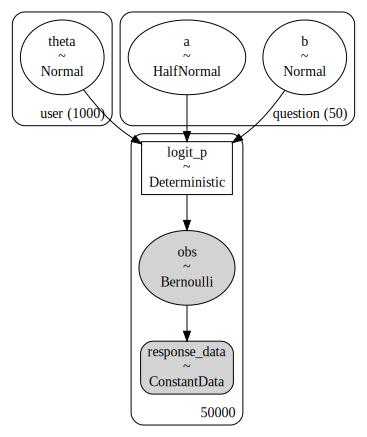

In [7]:
coords = {"user": users, "question": questions}

model1 = pm.Model(coords=coords)

with model1:
    response_data = pm.ConstantData("response_data", response)

    # 能力値
    theta = pm.Normal("theta", mu=0, sigma=1, dims="user")

    #　識別力
    a = pm.HalfNormal("a", sigma=1, dims="question")
    b = pm.Normal("b", mu=0, sigma=1, dims="question")

    logit_p = pm.Deterministic(
        "logit_p", a[question_idx] * (theta[user_idx] - b[question_idx])
        )
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_data)

g = pm.model_to_graphviz(model1)
display(g)

In [8]:
%%time

with model1:
    idata1 = pm.sample(random_seed=42)

CPU times: user 15min 31s, sys: 6.3 s, total: 15min 37s
Wall time: 18min 46s


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


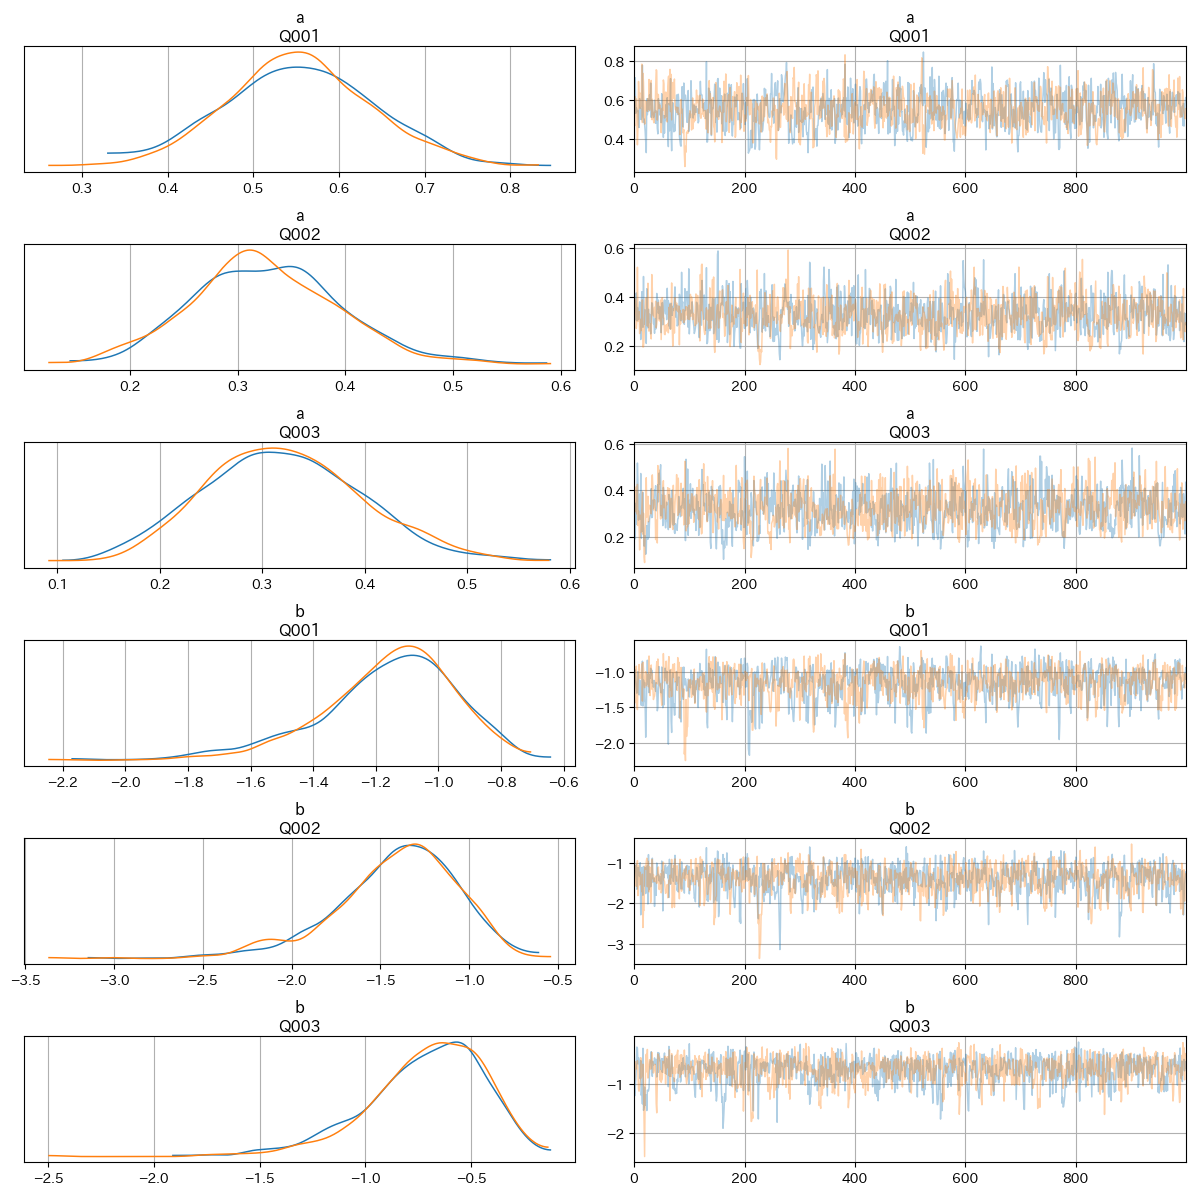

In [9]:
coords_q = {"question": ["Q001", "Q002", "Q003"]}
az.plot_trace(
    idata1, var_names=["a", "b"],
    coords=coords_q,
    compact=False
)
plt.tight_layout()
plt.show()

## 詳細分析
そもそもの目的：問題ごと・受験者ごとの特性を分析するということ。まずはsummaryを見てみる。

これで、能力値と識別力が大まかにわかる。

In [10]:
summary_a1 = az.summary(idata1, var_names=["a"])
summary_b1 = az.summary(idata1, var_names=["b"])

display(summary_a1)
display(summary_b1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[Q001],0.553,0.087,0.389,0.714,0.003,0.002,853.0,1019.0,1.0
a[Q002],0.327,0.069,0.195,0.450,0.002,0.001,1071.0,953.0,1.0
a[Q003],0.322,0.078,0.182,0.467,0.003,0.002,667.0,784.0,1.0
a[Q004],0.691,0.095,0.518,0.870,0.003,0.002,830.0,1074.0,1.0
a[Q005],0.756,0.104,0.572,0.957,0.003,0.002,1146.0,1377.0,1.0
a[Q006],0.616,0.089,0.455,0.784,0.003,0.002,851.0,957.0,1.0
a[Q007],0.541,0.081,0.379,0.681,0.003,0.002,890.0,1006.0,1.0
a[Q008],0.285,0.063,0.167,0.397,0.002,0.001,1119.0,1517.0,1.0
a[Q009],0.504,0.081,0.347,0.649,0.003,0.002,976.0,1010.0,1.0
a[Q010],0.540,0.086,0.372,0.698,0.003,0.002,1170.0,981.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Q001],-1.163,0.220,-1.552,-0.765,0.008,0.006,907.0,862.0,1.00
b[Q002],-1.410,0.346,-2.123,-0.845,0.011,0.009,1064.0,843.0,1.00
b[Q003],-0.714,0.277,-1.228,-0.243,0.010,0.008,901.0,740.0,1.00
b[Q004],-1.800,0.247,-2.285,-1.374,0.009,0.007,808.0,891.0,1.00
b[Q005],-2.340,0.292,-2.903,-1.841,0.009,0.006,1167.0,1396.0,1.00
b[Q006],-1.425,0.218,-1.812,-1.006,0.008,0.005,878.0,1036.0,1.00
b[Q007],-2.112,0.319,-2.684,-1.522,0.011,0.008,954.0,948.0,1.00
b[Q008],-1.851,0.436,-2.689,-1.093,0.013,0.010,1132.0,1299.0,1.00
b[Q009],1.251,0.231,0.831,1.686,0.008,0.006,966.0,885.0,1.00
b[Q010],1.287,0.226,0.890,1.728,0.007,0.005,1217.0,1179.0,1.00


In [11]:
summary_theta1 = az.summary(idata1, var_names=["theta"])
display(summary_theta1.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[USER0001],0.277,0.468,-0.530,1.191,0.010,0.010,2021.0,1371.0,1.0
theta[USER0002],0.007,0.457,-0.889,0.834,0.010,0.010,2149.0,1542.0,1.0
theta[USER0003],1.244,0.518,0.343,2.310,0.010,0.008,2872.0,1393.0,1.0
theta[USER0004],-0.766,0.452,-1.512,0.148,0.010,0.008,2248.0,1484.0,1.0
theta[USER0005],-0.539,0.477,-1.431,0.304,0.011,0.009,1759.0,1646.0,1.0


## 偏差値と能力値の関係？
- 偏差値：平均点の受験者を偏差値50とし、1σ分上がれば偏差値60.
- 能力値：今回、偏差値と同じ定義で計算してみる



In [12]:
df_sum1 = pd.DataFrame((df.mean(axis=1)*100), columns=["素点"])

X = df_sum1.copy()

X_mean, X_std = X.mean(), X.std()
X = (X-X_mean) / X_std * 10 + 50
df_sum1["偏差値"] = X

#　受験者ごとの能力値の平均
x1 = summary_theta1["mean"]
print(x1)

x1_mean, x1_std = x1.mean(), x1.std()
x1 = (x1.values - x1_mean) / x1_std * 10 + 50
df_sum1["能力値"] = x1

display(df_sum1.head())


theta[USER0001]    0.277
theta[USER0002]    0.007
theta[USER0003]    1.244
theta[USER0004]   -0.766
theta[USER0005]   -0.539
                   ...  
theta[USER0996]    0.459
theta[USER0997]    0.177
theta[USER0998]    0.633
theta[USER0999]    0.239
theta[USER1000]   -0.937
Name: mean, Length: 1000, dtype: float64


,素点,偏差値,能力値
USER0001,64.0,53.306720,52.847681
USER0002,58.0,48.448659,49.599101
USER0003,78.0,64.642196,64.482411
USER0004,48.0,40.351891,40.298536
USER0005,50.0,41.971245,43.029750


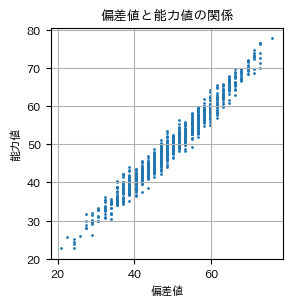

In [13]:
plt.scatter(df_sum1["偏差値"], df_sum1["能力値"], s=1)
plt.title("偏差値と能力値の関係")
plt.xlabel("偏差値")
plt.ylabel("能力値")
plt.show()

点数が同じなら、偏差値も必ず同じにある。しかし、能力値は10ポイント程度ばらつきが出る。⇨偏差値の評価よりもさらに精緻に評価できる**可能性**がある、ことを示唆している。


## 同じ偏差値だけど能力値が違うのはなぜ？
以下のケースで確認する。

1. 素点が62（偏差値51.69）の受験者を抽出
2. 素点が62点で能力値が最も高い受験者を抽出: `USER0064`
3. 素点が62点で能力値が最も低い受験者を抽出: `USER0463`

この２人の受験者が正解した問題の平均困難度も計算する。


In [13]:
df_62_1 = df_sum1.query("素点==62")
print(f"素点62点の受験者数：{len(df_62_1)}\n")

argmin1 = df_62_1["能力値"].values.argmin()
print("素点62点で能力値が一番低い受験者\n", df_62_1.iloc[argmin1], "\n")

argmax1 =df_62_1["能力値"].values.argmax()
print("素点62点で能力値が一番高い受験者\n", df_62_1.iloc[argmax1], "\n")

In [37]:
# 二人の受験者の問題ごとの正答を抽出
w1 = df.loc[["USER0463", "USER0064"]]
print("w1 dataframe \n")
display(w1)
w2 = w1.sum(axis=1)
print(f"w1のshape: {w1.shape}\n正解数：\n{w2}\n")

#　問題別の平均困難度
b_mean1 = az.summary(
    idata1, var_names=["b"])["mean"].values.reshape(1, -1)
print(b_mean1)
print(f"b_meanのshape: {b_mean1.shape}\n")

#　二人の受験者が解いた問題の平均困難度
w3 = (w1 * b_mean1).sum(axis=1) / w2[0]   #　受験者ごとの解答状況(0 or 1)と困難度のベクトルで内積をとった。⇨正答した問題の平均困難度
print(f"w3: \n{w3}")

w1 dataframe 



,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0463,0,0,1,1,1,1,1,1,0,0,1,0,1,0,0,0,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,0,0,1,1
USER0064,1,0,1,1,1,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,1


w1のshape: (2, 50)
正解数：
USER0463    31
USER0064    31
dtype: int64

[[-1.163 -1.410 -0.714 -1.800 -2.340 -1.425 -2.112 -1.851  1.251  1.287
  -0.580 -1.943 -0.682  0.288 -0.090  0.329  0.073 -2.375 -1.767 -1.053
  -1.560 -1.828  1.349 -1.503  1.288  1.070 -1.692 -0.289 -1.948 -2.194
  -0.180  0.008 -0.935 -0.649 -1.272  0.262 -1.561 -1.404 -2.080  0.594
  -0.067 -1.305 -2.845 -1.379  0.614  0.450  0.521 -1.756 -1.996 -1.896]]
b_meanのshape: (1, 50)

w3: 
USER0463   -1.209000
USER0064   -1.115645
dtype: float64


- 二人の受験者共に３１問正解している
- 個別の問題単位で生後状況が異なる
- 正答の平均困難度は`USER0064` > `USER0463`→`USER0064`の方が、難しい問題にたくさん回答できているということ



/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


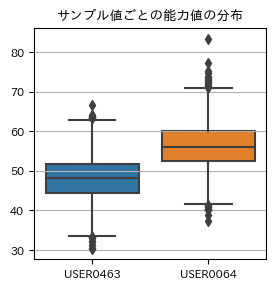

In [26]:
# USER0463とUSER0064の能力値のサンプルデータを抽出
w1 = idata1["posterior"].data_vars["theta"].loc[:,:,["USER0463", "USER0064"]].values   # .data_varsはなくても同じだと思われる

#　軸の順番を入れ替え、受験者を第一要素とする行列へ変換
w2 = w1.transpose().reshape(2, -1)

#　能力値のスケールを変更
w3 = (w2 - x1_mean) / x1_std * 10 + 50

#　受験者を列名とするデータフレームへ変換
df_w3 = pd.DataFrame(w3.T, columns=["USER0463", "USER0064"])

# seabornのboxplot
sns.boxplot(df_w3)
plt.title("サンプル値ごとの能力値の分布")
plt.show()

In [ ]:
w1.transpose()

- 二人の受験者の能力値にはほとんどオーバーラップがないといえる
- 実は`USER0064`の方が能力値が高い傾向にあるが、試験の出来が偶然に通っていて同じ偏差値=同じ能力と診断されたのだった

# 変分推論法の利用
- 観測地の個数が多いと、処理時間が非常に長くなりやすい
- 先ほどの例は観測値の個数=1000人、50000個　⇨ もし5万人分のデータがあったら？

変分推論法で計算量を抑えながら、同じような答えを得られることをみよう。

以下の`model2`で変分推論法を用いるには
1. fit関数
2. 収束確認
3. サンプリング
の３ステップを実行する必要がある。

In [40]:
# model1とモデル定義は同じ⇨改めてmodel2とする
coords = {"user": users, "question": questions}

model2 = pm.Model(coords=coords)

with model2:
    response_data = pm.ConstantData("response_data", response)

    # 能力値
    theta = pm.Normal("theta", mu=0, sigma=1, dims="user")

    #　識別力
    a = pm.HalfNormal("a", sigma=1, dims="question")
    b = pm.Normal("b", mu=0, sigma=1, dims="question")

    logit_p = pm.Deterministic(
        "logit_p", a[question_idx] * (theta[user_idx] - b[question_idx])
        )
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_data)

In [44]:
%%time
# fit関数
with model2:
    mean_field = pm.fit(method=pm.ADVI(), n=20000, obj_optimizer=pm.adam())


CPU times: user 3min, sys: 887 ms, total: 3min 1s
Wall time: 3min 14s


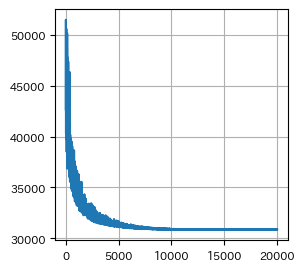

In [45]:
# 収束確認
plt.plot(mean_filed.hist)
plt.show()

In [46]:
# サンプリング
%%time

idata2 = mean_field.sample(2000)

CPU times: user 2.63 s, sys: 1.75 s, total: 4.38 s
Wall time: 15.5 s


In [47]:
summary_theta2 = az.summary(idata2, var_names=["theta"])

df_sum2 = df_sum1.copy()

x2 = summary_theta2["mean"].values

x2_mean, x2_std = x2.mean(), x2.std()
x2 = (x2-x2_mean) / x2_std * 10 + 50
df_sum2["能力値2"] = x2

display(df_sum2.head(10))

Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,素点,偏差値,能力値,能力値2
USER0001,64.0,53.306720,52.847681,52.934141
USER0002,58.0,48.448659,49.599101,49.785000
USER0003,78.0,64.642196,64.482411,64.970062
USER0004,48.0,40.351891,40.298536,40.075148
USER0005,50.0,41.971245,43.029750,42.604004
USER0006,62.0,51.687367,48.997512,48.985786
USER0007,52.0,43.590598,41.898763,41.625862
USER0008,54.0,45.209952,44.882644,44.464860
USER0009,60.0,50.068013,49.334402,49.319786
USER0010,62.0,51.687367,49.298307,49.284000


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


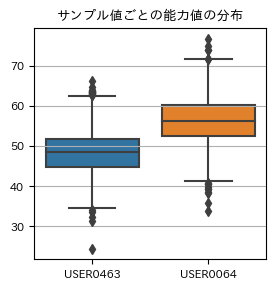

In [48]:
# USER0463とUSER0064の能力値のサンプルデータを抽出
w1 = idata2["posterior"].data_vars["theta"].loc[:,:,["USER0463", "USER0064"]].values   # .data_varsはなくても同じだと思われる

#　軸の順番を入れ替え、受験者を第一要素とする行列へ変換
w2 = w1.transpose().reshape(2, -1)

#　能力値のスケールを変更
w3 = (w2 - x2_mean) / x1_std * 10 + 50

#　受験者を列名とするデータフレームへ変換
df_w3 = pd.DataFrame(w3.T, columns=["USER0463", "USER0064"])

# seabornのboxplot
sns.boxplot(df_w3)
plt.title("サンプル値ごとの能力値の分布")
plt.show()